# Modelling Galaxy Masses Using a Neural Network

In [14]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In cosmology, calculating masses of galaxies is an important part of understanding galactic structure and dynamics. Discrepancies between the total baryonic mass of a galaxy and its mass as inferred from its dynamics was crucial in the discovery of dark matter, and being able to deduce the total mass of a galaxy from its light and colours remains an important exercise in improving scientific understanding of galaxies and cosmology. [Francis et al. (2025)](https://ui.adsabs.harvard.edu/link_gateway/2025AJ....169..186D/doi:10.3847/1538-3881/adaf21) present a model to convert Wide-field Infrared Spectroscopy Explorer (WISE) W1-band fluxes into stellar masses. As part of their work, they include a table of total stellar masses of a number of galaxies, alongside their total luminosity in the W1 band and g-W1 photometric colours. In this report, I train and test a neural network on this dataset. Specifically, this model retrieves the total mass of a galaxy based on inputs of galaxy luminosity and g-W1 colour.

The raw data from the study, retrieved from [SPARC](https://astroweb.case.edu/SPARC/) (associated with [Lelli, McGaugh and Schombert, 2016](https://ui.adsabs.harvard.edu/link_gateway/2016AJ....152..157L/doi:10.3847/0004-6256/152/6/157)), can be found in `wise_ii.table1.txt`. We start by extracting and viewing the data:

In [15]:
# load data
data = "wise_ii.table1.txt"
with open(data) as f:
    lines = f.readlines()

# process data
data = []
for line in lines[16:]: # remove header
    values = line.split()
    data.append([v for v in values])

data = pd.DataFrame(data, columns=['Galaxy', 'LogL', 'LogM', 'err_M', 'g-W1', 'M/L'])
data = data.astype({'Galaxy': 'str','LogL': 'float', 'LogM': 'float', 'err_M': 'float', 'g-W1': 'float', 'M/L': 'float'})
data = data.sample(frac=1).reset_index(drop=True) # shuffle data in case of bias in ordering
data

,Galaxy,LogL,LogM,err_M,g-W1,M/L
0,UGC09992,8.384,8.138,0.058,3.00,0.57
1,UGC06930,10.014,9.749,0.019,2.73,0.54
2,UGC06973,10.691,10.346,0.003,4.78,0.45
3,UGC06628,9.808,9.557,0.033,2.98,0.56
4,F568-V1,9.439,9.174,0.036,2.85,0.54
...,...,...,...,...,...,...
106,NGC3917,10.311,10.356,0.006,3.99,1.11
107,UGCA442,8.080,7.828,0.060,0.84,0.56
108,NGC4013,10.862,10.769,0.002,4.52,0.81
109,NGC5005,11.245,11.286,0.002,3.95,1.10


Note that due to large numbers, we are dealing with logarithmic masses and luminosities. Both of these values are scaled according to solar quantities. g-W1 colours are in units of magnitude.

## Model Description

The model takes in two input variables:
1. $x_1=\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$
2. $x_2=g-\mathrm{W1}$

And produces one output:
1. $y_1=\log_{10}(\mathrm{Mass}/\mathrm{M}_\odot)$

We can visualise the training data using a 2D histogram of mass in the colour-luminosity plane, as well as plotting dependencies between the inputs and output individually. Note that the inputs have been normalised between 0 and 1 as is best practice.

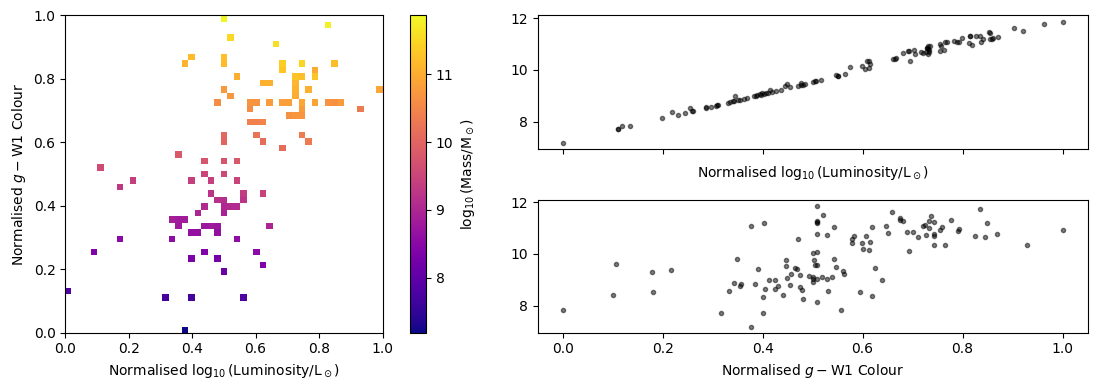

In [16]:
# set x and y
x = np.column_stack([data['LogL'], data['g-W1']])
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0)) # normalise
y = np.array(data['LogM']).reshape([-1,1])

# Create bins and setup 2D histogram
x_bins = np.linspace(x[:,0].min(), x[:,0].max(), 50)
y_bins = np.linspace(x[:,1].min(), x[:,1].max(), 50)
stat, x_edges, y_edges, binnumber = stats.binned_statistic_2d(x[:,0], x[:,1], y[:,0], statistic='mean', bins=[x_bins, y_bins])

# plotting
fig = plt.figure(figsize=(12, 4), tight_layout=True)

ax1 = fig.add_subplot(121)
im = ax1.imshow(stat, origin='lower', aspect='equal',
           extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
           cmap='plasma')
clb = plt.colorbar(im, label=r'$\log_{10}(\mathrm{Mass}/\mathrm{M}_\odot)$')
ax1.set_xlabel(r'Normalised $\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$')
ax1.set_ylabel(r'Normalised $g-\mathrm{W1}$ Colour')

ax2 = fig.add_subplot(222)
ax2.plot(x[:,0], y, 'k.', alpha=0.5)
ax2.set_xticklabels([])
ax2.set_xlabel(r'Normalised $\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$')

ax3 = fig.add_subplot(224)
ax3.plot(x[:,1], y, 'k.', alpha=0.5)
ax3.set_xlabel(r'Normalised $g-\mathrm{W1}$ Colour')

plt.show()

The above plots demonstrate a strong linear correlation between logarithmic luminosity and logarithmic mass, and a more scattered but still somewhat positive linear relation between g-W1 colour and logarithmic mass. We now split data into training, validation, and test sets using the 70/20/10 rule.

In [17]:
# split into training, validation, test sets
train_size = int(0.7 * len(x))
valid_size = int(0.2 * len(x))
test_size = len(x) - train_size - valid_size

x_train, x_valid, x_test = x[:train_size], x[train_size:train_size+valid_size], x[-test_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size+valid_size], y[-test_size:]

# check shapes
print("Training Data: {} {}".format(x_train.shape, y_train.shape))
print("Validation Data: {} {}".format(x_valid.shape, y_valid.shape))
print("Test Data: {} {}".format(x_test.shape, y_test.shape))

Training Data: (77, 2) (77, 1)
Validation Data: (22, 2) (22, 1)
Test Data: (12, 2) (12, 1)


## Network Architecture

### Activation Functions

Since this is a network for regression dealing with largely linear relationships, we use the ReLU activation function and linear output for regression. The below cell defines `relu(x)` and `linear(x)` as well as `relu_derivative(x)` for backpropagation.

In [18]:
# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# linear output for regression
def linear(x):
    return x

# ReLU derivative
def relu_derivative(x):
    results = np.ones_like(x)
    results[x < 0] = 0
    return results

### Network Structure

We can define the sizes of the network layers as follows:

In [19]:
# network sizes
input_layer = 2
hidden_layer = 8 # somewhat arbitrary choice
output_layer = 1

total_neurons = input_layer + hidden_layer + output_layer
print(f"Total neurons in network: {total_neurons}")

Total neurons in network: 11


We can also graphically represent the network structure as

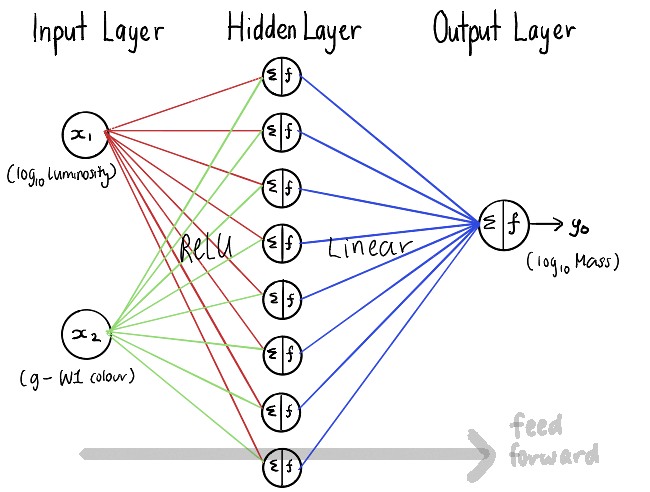

### Initialisation

Then we initialise weights and biases. Weights are initialised using a normal distribution with variance corresponding to the number of neurons. The randomness introduced as a result of this step speeds up training. Biases as simply initialised as zero vectors of size corresponding to the number of neurons in each layer.

In [20]:
# initialize weights and biases
init_scale = 0.01 # scale for better stability
rng = np.random.default_rng(42) # seed for reproducibility

w1 = init_scale * rng.normal(0, np.sqrt(2/input_layer), size=(hidden_layer, input_layer))
b1 = np.zeros((hidden_layer, 1))
w2 = init_scale * rng.normal(0, np.sqrt(2/hidden_layer), size=(output_layer, hidden_layer))
b2 = np.zeros((output_layer, 1))

Finally, we define the network functions, as previously discussed (ReLU for inputs to hidden layer and linear for hidden layer to output).

In [21]:
# defining network functions
def f_z(x,w,b):
    return (np.matmul(w, x.T)+b).T
# from inputs to hidden layer
def f_y1(x, w1, b1):
    z1 = f_z(x, w1, b1)
    return relu(z1)
# from hidden layer to output
def f_y2(y1, w2, b2):
    z2 = f_z(y1, w2, b2)
    return linear(z2)
# full feed forward
def feed_forward(x,w1,b1,w2,b2):
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)
    return y2

## Network Training

### Loss Function

Loss is taken to be a Root Mean Squared Error (RMSE) function as this is an efficient way to calculate the difference between the true and predicted values for $\log_{10}\mathrm{Mass}$. That is,
$$\text{Loss}_\text{RMSE}=\left(\frac{1}{111}\sum_{i=1}^{111}(y_{i,\text{true}}-y_{i,\text{pred}})\right)^{1/2}$$

In [22]:
# define loss function (RMSE)
def loss_rmse(y_true, y_pred):
    y_t = np.asarray(y_true)
    y_p = np.asarray(y_pred)
    return np.sqrt(np.mean((y_t - y_p)**2))

### Gradient Equations

If we set $y$, $y_1$ and $y_2$ to be the true output, and the outputs of the hidden and output layers, respectively, and note that the linear output function results in $z_2=y_2$, then the loss function is
$$L=\left(\frac{1}{111}\sum_{j=1}^{111}(y_j-y_{2j})^2\right)^{1/2}=\left(\frac{1}{111}\sum_{j=1}^{111}(y_j-z_{2j})^2\right)^{1/2}$$
The derivative over $z_{2i}$ is then
$$\frac{\partial{L}}{\partial{z_{2i}}}=\frac{1}{2}\left(\frac{1}{111}\sum_{j=1}^{111}(y_j-z_{2j})^2\right)^{-1/2}\cdot-2\delta_{ji}\sum_{j=1}^{111}(y_j-z_{2j})=\frac{y_{2i}-y_i}{L}$$
Using the chain rule to get derivatives over $w_2$ and $b_2$, where $k$ indexes the size of the training set i.e. $k\in[1,111]$, $j$ indexes the hidden layer i.e. $k\in[1,8]$, and $i$ indexes the output layer i.e. $i\in[1]$:
$$\frac{\partial{L}}{\partial{w_{2ij}}}=\sum_{k}\left(\frac{\partial{L}}{\partial{z_{2ki}}}\right)^T\frac{\partial{z_{2ki}}}{\partial{w_{2ij}}}=\sum_{k}\left(\frac{\partial{L}}{\partial{z_{2ki}}}\right)^Ty_{1kj}$$
$$\frac{\partial{L}}{\partial{b_{2i}}}=\sum_{k}\left(\frac{\partial{L}}{\partial{x_{2ki}}}\right)^T\frac{\partial{z_{2ki}}}{\partial{b_{2i}}}=\sum_{k}\frac{\partial{L}}{\partial{z_{2ki}}}$$
We can continue in the same way to get derivatives with respect to $z_1$, $w_1$, and $b_1$, noting that $q\in[1,222]$ indexes the shape and subscript of $x$ as $x_{kq}$:
$$\frac{\partial L}{\partial z_{1kj}} = \sum \limits_{i}\frac{\partial L}{\partial z_{2ki}} \frac{\partial z_{2ki}}{\partial y_{1kj}} \frac{\partial y_{1kj}}{\partial z_{1kj}} =  \sum \limits_{i} \frac{\partial L}{\partial z_{2ki}}w_{2ij}\frac{\partial y_{1kj}}{\partial z_{1kj}}$$
$$\frac{\partial L}{\partial w_{1jq}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)^T \frac{\partial z_{1kj}}{\partial w_{1jq}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)^T x_{kq}$$
$$\frac{\partial L}{\partial b_{1j}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)^T \frac{\partial z_{1kj}}{\partial b_{1j}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)$$
Implementing all of the above into code as function `gradient_descent`:

In [23]:
def gradient_descent(x,y,w1,b1,w2,b2):

    z1 = f_z(x, w1, b1)
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)

    dLdz2 = (y2-y) / loss_rmse(y, y2)
    dLdw2 = np.matmul(dLdz2.T, y1) / len(y1)
    dLdb2 = np.sum(dLdz2, axis=0).reshape([-1,1]) / len(y1)

    dy1dz1 = relu_derivative(z1)

    dLdz1 = np.matmul(dLdz2, w2) * dy1dz1 / len(y1)
    dLdw1 = np.matmul(dLdz1.T, x)
    dLdb1 = np.sum(dLdz1, axis=0).reshape([-1,1])

    return {'dLdw1': dLdw1, 'dLdw2': dLdw2, 'dLdb1': dLdb1, 'dLdb2': dLdb2}

## Train and Test Network

In [24]:
Nepoch = 10
l_rates = [0.1, 1]

def train_network(l_rate, Nepoch, w1=w1, b1=b1, w2=w2, b2=b2):

    # Make local copies so repeated calls don't mutate the global initial weights
    w1 = w1.copy()
    b1 = b1.copy()
    w2 = w2.copy()
    b2 = b2.copy()

    loss_train = np.zeros(Nepoch)
    loss_valid = np.zeros(Nepoch)
    loss_test = np.zeros(Nepoch)
    snapshots = []  # will hold per-epoch dictionaries of weights, grads, outputs, losses

    for step in range(Nepoch):
        # evaluate current losses and outputs
        output_train = feed_forward(x_train, w1, b1, w2, b2)
        loss_train[step] = loss_rmse(y_train, output_train)
        output_valid = feed_forward(x_valid, w1, b1, w2, b2)
        loss_valid[step] = loss_rmse(y_valid, output_valid)

        output_test = feed_forward(x_test, w1, b1, w2, b2)
        loss_test[step] = loss_rmse(y_test, output_test)

        # compute gradients on training set
        grad = gradient_descent(x_train, y_train, w1, b1, w2, b2)

        # record snapshot for this epoch
        snap = {
            'step': step+1,
            'w1': w1.tolist(),
            'b1': b1.tolist(),
            'w2': w2.tolist(),
            'b2': b2.tolist(),
            'dLdw1': grad['dLdw1'].tolist(),
            'dLdb1': grad['dLdb1'].tolist(),
            'dLdw2': grad['dLdw2'].tolist(),
            'dLdb2': grad['dLdb2'].tolist(),
            'output_test': output_test.flatten().tolist(),
            'loss_test': float(loss_test[step]),
        }
        snapshots.append(snap)

        # update weights
        w1 = w1 - l_rate * grad['dLdw1']
        b1 = b1 - l_rate * grad['dLdb1']
        w2 = w2 - l_rate * grad['dLdw2']
        b2 = b2 - l_rate * grad['dLdb2']

    return loss_train, loss_valid, snapshots

Wrote Python pickle snapshots to snapshots_lr_0.1.pkl
Wrote Python pickle snapshots to snapshots_lr_1.pkl

Learning rate = 0.1


,w1_mean,w2_mean,b1_mean,b2_mean,dLdw1_mean,dLdw2_mean,dLdb1_mean,dLdb2_mean,output_test_mean,loss_test
step,,,,,,,,,,
1,-0.000561,0.000275,0.000000,0.000000,0.000150,-0.003193,0.000265,-0.993650,-0.000036,10.033438
2,-0.000576,0.000595,-0.000026,0.099365,-0.000030,-0.003152,-0.000052,-0.993522,0.099363,9.934790
3,-0.000573,0.000910,-0.000021,0.198717,-0.000208,-0.003161,-0.000364,-0.993390,0.198748,9.836172
4,-0.000552,0.001226,0.000015,0.298056,-0.000386,-0.003222,-0.000677,-0.993253,0.298120,9.737581
5,-0.000513,0.001548,0.000083,0.397382,-0.000568,-0.003335,-0.000997,-0.993113,0.397482,9.639018
6,-0.000456,0.001882,0.000183,0.496693,-0.000756,-0.003499,-0.001327,-0.992968,0.496835,9.540479
7,-0.000381,0.002232,0.000315,0.595990,-0.000954,-0.003718,-0.001674,-0.992818,0.596181,9.441964
8,-0.000285,0.002604,0.000483,0.695271,-0.001164,-0.003994,-0.002042,-0.992664,0.695523,9.343471
9,-0.000169,0.003003,0.000687,0.794538,-0.001390,-0.004330,-0.002437,-0.992505,0.794864,9.244996



Learning rate = 1


,w1_mean,w2_mean,b1_mean,b2_mean,dLdw1_mean,dLdw2_mean,dLdb1_mean,dLdb2_mean,output_test_mean,loss_test
step,,,,,,,,,,
1,-0.000561,0.000275,0.000000,0.000000,1.501252e-04,-0.003193,2.648987e-04,-0.993650,-0.000036,10.033438
2,-0.000711,0.003469,-0.000265,0.993650,-1.606152e-03,-0.002806,-2.736352e-03,-0.992169,0.993903,9.047756
3,0.000895,0.006274,0.002471,1.985819,-3.247717e-03,-0.007323,-5.664179e-03,-0.990108,1.987117,8.064801
4,0.004143,0.013598,0.008136,2.975928,-7.424029e-03,-0.016626,-1.287222e-02,-0.987123,2.982610,7.082344
5,0.011567,0.030224,0.021008,3.963050,-1.693995e-02,-0.037753,-2.914381e-02,-0.982530,3.997543,6.084377
6,0.028507,0.067977,0.050152,4.945580,-3.862297e-02,-0.085474,-6.568818e-02,-0.974442,5.123518,4.981125
7,0.067130,0.153451,0.115840,5.920022,-8.764595e-02,-0.190998,-1.451787e-01,-0.949608,6.834693,3.307642
8,0.154776,0.344449,0.261019,6.869630,1.589660e-01,0.388947,3.200495e-01,0.930706,11.494769,1.638030
9,-0.004190,-0.044498,-0.059031,5.938924,5.135170e-07,-0.000003,4.027640e-07,-0.962014,5.938924,4.202183


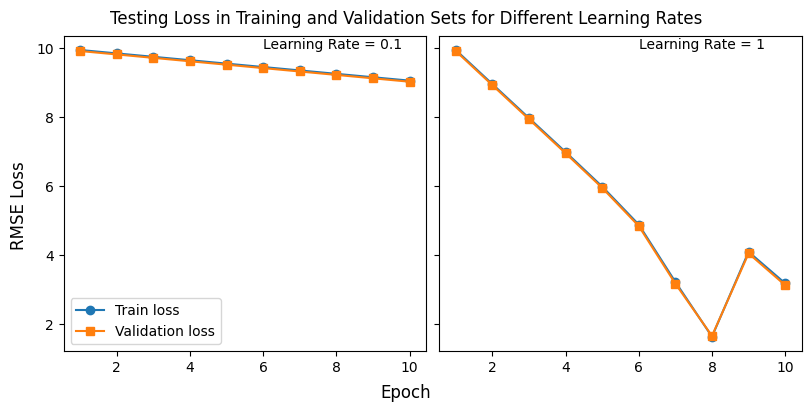

In [25]:
fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True, constrained_layout=True)
epochs = np.arange(1, Nepoch+1)

tables = {}
for idx, lr in enumerate(l_rates):
    loss_train, loss_valid, snapshots = train_network(lr, Nepoch)

    ax[idx].plot(epochs, loss_train, marker='o', label='Train loss')
    ax[idx].plot(epochs, loss_valid, marker='s', label='Validation loss')
    ax[idx].text(6, 10, f"Learning Rate = {lr}")

    # Save Python-native pickle for quick reload (Python-only; insecure for untrusted files)
    import pickle
    pklname = f'snapshots_lr_{lr}.pkl'
    with open(pklname, 'wb') as pf:
        pickle.dump(snapshots, pf, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Wrote Python pickle snapshots to {pklname}")

    n_epochs = len(snapshots)
    rows = []
    for i in range(n_epochs):
        s = snapshots[i]
        # convert stored lists back to numpy arrays for simple stats
        def arr_mean(key):
            v = s.get(key, [])
            return np.mean(np.asarray(v).flatten())
        rows.append({
            'step': i+1,
            'w1_mean': arr_mean('w1'),
            'w2_mean': arr_mean('w2'),
            'b1_mean': arr_mean('b1'),
            'b2_mean': arr_mean('b2'),
            'dLdw1_mean': arr_mean('dLdw1'),
            'dLdw2_mean': arr_mean('dLdw2'),
            'dLdb1_mean': arr_mean('dLdb1'),
            'dLdb2_mean': arr_mean('dLdb2'),
            'output_test_mean': arr_mean('output_test'),
            'loss_test': s.get('loss_test', np.nan)
        })
    df = pd.DataFrame(rows).set_index('step')
    tables[lr] = df

ax[0].legend(loc='lower left')
fig.suptitle("Testing Loss in Training and Validation Sets for Different Learning Rates")
fig.supxlabel("Epoch")
fig.supylabel("RMSE Loss")

for lr, df in tables.items():
    print(f"\nLearning rate = {lr}")
    display(df)